## 인프런 2020년 새해 다짐 이벤트 댓글 분석
* https://www.inflearn.com/pages/newyear-event-20200102
* 영상 튜토리얼 : [댓글 수백 수천개 분석하기?! [1/5] 이벤트 데이터 크롤링 feat. 인프런 새해 다짐 이벤트 - YouTube](https://www.youtube.com/watch?v=OUSwQk79H8I&list=PLaTc2c6yEwmohRzCxWQqJ7Z9aqc-sQ5gC)

## 기획자나 마케터가 되어 이벤트 댓글을 분석해 보자!
### 내가 만약 수백 수천개의 댓글을 다 읽어봐야 한다면?
### 댓글 속에 제품에 대한 관심을 빈도수로 추출해야 한다면?
* 쇼핑몰에서 제품 관련 이벤트 진행시 어떤 제품을 고객이 선호하는지 알고 싶다면?
* 고객 DB와 연계할 수 있다면 이벤트 혹은 마케팅 세그먼트로 활용해 볼 수도 있지 않을까?

### 향후 마케팅이나 전략을 어떻게 세워야 할까?

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
# 정규표현식. regexpression
import re
import matplotlib.pyplot as plt

%matplotlib inline
# 시각화 결과가 선명하게 표시되도록
%config InlineBackend.figure_format = 'retina'

## 시각화를 위한 한글폰트 설정

In [2]:
# Window 한글폰트 설정
plt.rc("font", family="Malgun Gothic")
# Mac 한글폰트 설정
#plt.rc("font", family="AppleGothic")
#plt.rc('axes', unicode_minus=False)

## 크롤링한 파일 로드하기

In [3]:
# df 라는 변수에 이벤트 댓글 파일을 로드합니다.
df = pd.read_csv("inflearn-event.csv")
df.shape

(100, 1)

In [4]:
# head 로 미리보기 합니다.
df.head()

,text
0,2020년 목표: 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 : 스프링 ...
1,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
2,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
3,2020년 목표 : 리액트 공부하기
4,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급


In [5]:
# tail 로 미리보기 합니다.
df.tail()

,text
95,"사이버수사대(디지털포렌식)를 지원하고 싶은 현직 경찰관입니다. 현재는 아는 것도, ..."
96,"퇴사한지 2년 (헉 벌써…) 되가는 백수 개발자입니다. 현재 리액트, 노드, 파이어..."
97,"취업 성공~~!!!\n#관심강의: 스프링, 자바, Swift"
98,"올해는 파이썬, 데이터 분석, 머신러닝을 배워\n업무에 조금이라도 활용하고 싶습니다..."
99,오늘코드 사랑해요 ~ \n데이터 분석 기초를 둔둔하게~ \n#관심강의 : Oracl...


## 데이터 전처리

### 네트워크 오류 등으로 발생한 중복 입력 값을 제거
* 빈도 수 중복을 방지하기 위해

In [6]:
print(df.shape)
# drop_duplicates 를 통해 중복을 제거합니다. 이때 마지막 글을 남깁니다.
df = df.drop_duplicates(["text"], keep="last")
print(df.shape)

(100, 1)
(97, 1)


### 원본은 따로 보존

In [7]:
# 전처리 전에 원본을 보존하기 위해 origin_text 라는 컬럼에 복사해 둡니다.
df["origin_text"] = df["text"]
df.head()

,text,origin_text
0,2020년 목표: 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 : 스프링 ...,2020년 목표: 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 : 스프링 ...
1,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...
2,"2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는..."
4,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급
5,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!


### 소문자 변환

In [8]:
# "text" 파이썬은 대소문자를 구분하기 때문에 데이터 필터링을 위해 대문자를 모두 소문자로 변경
df["text"] = df["text"].str.lower()

In [9]:
# 같은 의미의 단어를 하나로 통일 예) python => 파이썬
# replace 는 텍스트가 완전히 일치될 때만 사용할 수 있습니다.
# 일부만 일치한다면 str.replace 를 사용하면 원하는 텍스트로 변경이 가능합니다.
df["text"] = df["text"].str.replace(
    "python", "파이썬").str.replace(
    "pandas", "판다스").str.replace(
    "javascript", "자바스크립트").str.replace(
    "java", "자바").str.replace(
    "react", "리액트")

### 텍스트로 관심 강의 분리

In [10]:
# 이 이벤트에는 "관심강의"라는 텍스트가 있습니다.
# "관심강의"를 기준으로 텍스트를 분리하고 관심강의 뒤에 있는 텍스트를 가져옵니다.
# 대부분 "관심강의"라는 텍스트를 쓰고 뒤에 강의명을 쓰기 때문입니다.
# 전처리한 내용은 실수를 방지하기 위해 "course" 라는 새로운 컬럼에 담습니다.
# "관심 강의", "관심 강좌" 에 대해서도 똑같이 전처리 합니다.
# ":" 특수문자를 빈문자로 바꿔줍니다.

df["course"] = df["text"].apply(lambda x: x.split("관심강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강의")[-1])
df["course"] = df["course"].apply(lambda x: x.split("관심 강좌")[-1])
df["course"] = df["course"].str.replace(":", "")
df["course"].head()

0    2020년  목표 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의  스프링 , 리액트
1    2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
2    2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ...
4                  40대 프로그래밍 시작!  우리를 위한 프로그래밍  파이썬 중급
5                       2020년 목표  돌머리 비전공자가 멋진 전공자 되기!
Name: course, dtype: object

In [11]:
# "text", "course" 전처리 내용 미리보기
df[["text", "course"]].head(10)

,text,course
0,2020년 목표: 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 : 스프링 ...,"2020년 목표 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 스프링 , 리액트"
1,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...
2,"2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...","2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ..."
4,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급
5,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!
6,2020 년목표: 비전공자(경영)가 전공자(it) 되기!!!,2020 년목표 비전공자(경영)가 전공자(it) 되기!!!
7,"2020년 목표 : 리액트 공부하기, 스프링 공부하기","2020년 목표 리액트 공부하기, 스프링 공부하기"
8,2020년에는 아이티 마스터가 되기 관심강의 리액트\n#관심강의 : 리액트로 nod...,리액트로 nodebird sns 만들기
9,2020년에는 아이티 마스터가 되기 관심강의 리액트,리액트
10,2020년 더욱 성장하는 올해가 되었으면 합니다 !! ㅎㅎㅎㅎ \n관심강의 : op...,"open cv , dl(tensorflow, keras, etc. ), nlp"


## 띄어 쓰기를 제거한 텍스트에서 키워드 추출
* TIOBE 프로그래밍 언어 순위 : [index | TIOBE - The Software Quality Company](https://www.tiobe.com/tiobe-index/?fbclid=IwAR34dJfgDHq2DK0C6X3g8IsUno2NhOiikMyxT6fw9SoyujFhy5FPvQogMoA)

In [12]:
# 특정 키워드가 들어가는 댓글을 찾습니다.
search_keyword = ['머신러닝', '딥러닝', '파이썬', '판다스', '공공데이터',
                  'django', '크롤링', '시각화', '데이터분석', 
                  '웹개발', '엑셀', 'c', '자바', '자바스크립트', 
                  'node', 'vue', '리액트']

# for 문을 통해 해당 키워드가 있는지 여부를 True, False값으로 표시하도록 합니다.
# 키워드에 따라 컬럼을 새로 만듭니다.
for keyword in search_keyword:
    df[keyword] = df["course"].str.contains(keyword)

In [13]:
# 미리보기 합니다.
df.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
0,2020년 목표: 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 : 스프링 ...,2020년 목표: 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 : 스프링 ...,"2020년 목표 프알못에서 프로젝트 마스터 되기 \n관심 있는 강의 스프링 , 리액트",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표: 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 ...,2020년 목표 스프링 열심히 공부하서 직장에서 사랑받고 싶어요!!\n관심 있는 강...,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,"2020년 목표: c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는...","2020년 목표: C++ 열심히 공부해서, 학교에서 꼭 A 맞기..!! \n관심있는...","2020년 목표 c++ 열심히 공부해서, 학교에서 꼭 a 맞기..!! \n관심있는 ...",False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 : 돌머리 비전공자가 멋진 전공자 되기!,2020년 목표 돌머리 비전공자가 멋진 전공자 되기!,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [14]:
# 파이썬|공공데이터|판다스 라는 텍스트가 들어가는 데이터가 있는지 찾습니다.
df_python = df[df["text"].str.contains("파이썬|공공데이터|판다스")].copy()
df_python.shape

(15, 20)

In [16]:
df_python.head()

,text,origin_text,course,머신러닝,딥러닝,파이썬,판다스,공공데이터,django,크롤링,시각화,데이터분석,웹개발,엑셀,c,자바,자바스크립트,node,vue,리액트
4,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! : 우리를 위한 프로그래밍 : 파이썬 중급,40대 프로그래밍 시작! 우리를 위한 프로그래밍 파이썬 중급,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
19,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,파이썬 데이터시각화 분석 실전 프로젝트 수강하고 싶어요,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False
22,머신러닝 제대로 배워보고 싶습니다.\n#관심강의 : 파이썬 머신러닝 완벽가이드,머신러닝 제대로 배워보고 싶습니다.\n#관심강의 : 파이썬 머신러닝 완벽가이드,파이썬 머신러닝 완벽가이드,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
26,"#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 ...","#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 ...","프로그래밍 시작하기 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기\n파...",False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
30,자바기반 웹 개발자입니다. 데이터 분석에 많이 쓰이는 파이썬이 궁금합니다.\n#관심...,자바기반 웹 개발자입니다. 데이터 분석에 많이 쓰이는 Python이 궁금합니다.\n...,"프로그래밍 시작하기 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기",False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [15]:
# 결과를 모두 더하면 해당 키워드의 등장 빈도수를 카운트 할 수 있습니다.
# search_keyword 컬럼만 가져와서 빈도수를 sum으로 더합니다. True = 1, False = 0
df[search_keyword].sum().sort_values(ascending=False)

c         18
리액트       15
파이썬       15
vue       11
자바         9
node       5
머신러닝       5
자바스크립트     4
공공데이터      4
시각화        3
딥러닝        2
크롤링        1
웹개발        0
엑셀         0
django     0
판다스        0
데이터분석      0
dtype: int64

In [17]:
# 공공데이터 텍스트가 들어가는 문장만 찾습니다.
# pandas 를 통해 볼때 문장이 길면 끝까지 보이지 않습니다.
# 문장의 전체를 보기 위해 for문을 통해 해당 텍스트를 순회하며 출력합니다.
# 이 때, 데이터 사이에 ------ 줄로 구분해서 표시하도록 합니다.
text = df.loc[(df["공공데이터"] == True), "text"]
for t in text:
    print("-"*20)
    print(t)

--------------------
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
파이썬의 고수가 되고싶어요
--------------------
자바기반 웹 개발자입니다. 데이터 분석에 많이 쓰이는 파이썬이 궁금합니다.
#관심강의: 프로그래밍 시작하기 : 파이썬 입문, 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
올해 안에 원하는 공부 다 끝내보려고요. 내년이면 수능이라..

#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기
--------------------
it개발자입니다. 개발을 오래 안하고 관리만 했더니 다시 개발이 너무 하고싶습니다. 올해는 인프런을 통해서 개발쪽 스킬셋을 업그레이드 하고 싶습니다!
#관심강의: 공공데이터로 파이썬 데이터 분석 시작하기


## 판다스 단어가 들어가는 텍스트만 찾기
* 이미 str.contains 를 통해 판다스가 들어가는 텍스트에 대해 컬럼을 만들어 놨습니다. 이 값이  True 라면 판다스 강좌 입니다.

In [18]:
# pandas 라는 텍스트가 들어가는 내용만 찾습니다.

df.loc[df["판다스"] == True, "text"]

Series([], Name: text, dtype: object)

## 빈도수 계산을 위한 텍스트 데이터 벡터화
* BOW 단어 가방에 단어를 토큰화 해서 담아줌

In [19]:
# "파이썬 데이터 분석" 이라는 텍스트를 토큰화 split 을 통해 해봅니다.
"파이썬 데이터 분석".split()

['파이썬', '데이터', '분석']

In [21]:
# 사이킷런의 CountVectorizer 를 통해 벡터화 합니다.
# vectorizer 라는 변수에 CountVectorizer 를 담습니다.
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다. 분리에 기준이 되는 것으로 기본 ','
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋습니다. 
                             ngram_range=(3, 6), # BOW(Bag Of Word)의 단위 갯수의 범위를 지정합니다. 최소한 3개 이상 6개 까지의 단어로 feature 개수를 지정
                             max_features = 2000 # 만들 피처의 수, 단어의 수
                            )
vectorizer

CountVectorizer(max_features=2000, min_df=2, ngram_range=(3, 6))

In [22]:
# df['course'] 만 벡터화 합니다.
feature_vector = vectorizer.fit_transform(df['course'])
feature_vector.shape

(97, 113)

In [23]:
# vectorizer 에서 get_feature_names 를 추출합니다.
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

113


['2020년 목표 리액트',
 '2020년 목표 리액트 공부하기',
 'age of vue',
 'age of vue js',
 'api 개발과 성능',
 'api 개발과 성능 최적화',
 'deep reinforcement learning',
 'deep reinforcement learning 파이썬',
 'deep reinforcement learning 파이썬 머신러닝',
 'jpa 활용2 api']

In [25]:
# 각 리뷰마다 등장하는 단어에 빈도수가 표현됩니다. 0 은 등장하지 않음을 의미합니다.
pd.DataFrame(feature_vector[:10].toarray(), columns=vocab).head(10)

,2020년 목표 리액트,2020년 목표 리액트 공부하기,age of vue,age of vue js,api 개발과 성능,api 개발과 성능 최적화,deep reinforcement learning,deep reinforcement learning 파이썬,deep reinforcement learning 파이썬 머신러닝,jpa 활용2 api,...,파이썬 입문 공공데이터로 파이썬 데이터,파이썬 입문 공공데이터로 파이썬 데이터 분석,프로그래밍 시작하기 파이썬,프로그래밍 시작하기 파이썬 입문,프로그래밍 시작하기 파이썬 입문 공공데이터로,프로그래밍 시작하기 파이썬 입문 공공데이터로 파이썬,홍정모의 따라하며 배우는,활용2 api 개발과,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# 위에서 구한 단어벡터를 더하면 단어가 전체에서 등장하는 횟수를 알 수 있습니다.
# 벡터화 된 피처를 확인해 봄
# Bag of words 에 몇 개의 단어가 들어있는지 확인
dist = np.sum(feature_vector, axis=0)
    
df_freq = pd.DataFrame(dist, columns=vocab)
df_freq

,2020년 목표 리액트,2020년 목표 리액트 공부하기,age of vue,age of vue js,api 개발과 성능,api 개발과 성능 최적화,deep reinforcement learning,deep reinforcement learning 파이썬,deep reinforcement learning 파이썬 머신러닝,jpa 활용2 api,...,파이썬 입문 공공데이터로 파이썬 데이터,파이썬 입문 공공데이터로 파이썬 데이터 분석,프로그래밍 시작하기 파이썬,프로그래밍 시작하기 파이썬 입문,프로그래밍 시작하기 파이썬 입문 공공데이터로,프로그래밍 시작하기 파이썬 입문 공공데이터로 파이썬,홍정모의 따라하며 배우는,활용2 api 개발과,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화
0,2,2,3,3,3,3,2,2,2,3,...,2,2,2,2,2,2,4,3,3,3


In [27]:
# 행과 열의 축을 T로 바꿔주고 빈도수로 정렬합니다.
df_freq.T.sort_values(by=0, ascending=False).head(30)

,0
리액트로 nodebird sns 만들기,5
nodebird sns 만들기,5
파이썬 데이터 분석,5
리액트로 nodebird sns,5
공공데이터로 파이썬 데이터 분석 시작하기,4
공공데이터로 파이썬 데이터,4
공공데이터로 파이썬 데이터 분석,4
파이썬 데이터 분석 시작하기,4
데이터 분석 시작하기,4
홍정모의 따라하며 배우는,4


In [28]:
# ["course", "freq"] 라는 컬럼명을 주어 위에서 만든 데이터프레임을 변환합니다.
df_freq_T = df_freq.T.reset_index()
df_freq_T.columns = ["course", "freq"]
df_freq_T.head()

,course,freq
0,2020년 목표 리액트,2
1,2020년 목표 리액트 공부하기,2
2,age of vue,3
3,age of vue js,3
4,api 개발과 성능,3


In [30]:
# 강의명을 토큰 3개로 중복제거하기 위해, 강좌명에서 지식공유자의 이름을 빈문자열로 변경합니다.
# 강의명을 lambda 식을 사용해서 x.split() 으로 나누고 [:4] 앞에서 4개까지만 텍스트를 가져오고 다시 join으로 합쳐줍니다. 
# 중복된 텍스트를 구분해서 보기 위함입니다.
df_freq_T["course_find"] = df_freq_T["course"].str.replace("홍정모의", "")
df_freq_T["course_find"] = df_freq_T["course_find"].apply(lambda x : " ". join(x.split()[:4]))
df_freq_T.sort_values(["course_find", "freq"], ascending=False).head(10)

,course,freq,course_find
111,활용2 api 개발과 성능,3,활용2 api 개발과 성능
112,활용2 api 개발과 성능 최적화,3,활용2 api 개발과 성능
110,활용2 api 개발과,3,활용2 api 개발과
106,프로그래밍 시작하기 파이썬 입문,2,프로그래밍 시작하기 파이썬 입문
107,프로그래밍 시작하기 파이썬 입문 공공데이터로,2,프로그래밍 시작하기 파이썬 입문
108,프로그래밍 시작하기 파이썬 입문 공공데이터로 파이썬,2,프로그래밍 시작하기 파이썬 입문
105,프로그래밍 시작하기 파이썬,2,프로그래밍 시작하기 파이썬
102,파이썬 입문 공공데이터로 파이썬,2,파이썬 입문 공공데이터로 파이썬
103,파이썬 입문 공공데이터로 파이썬 데이터,2,파이썬 입문 공공데이터로 파이썬
104,파이썬 입문 공공데이터로 파이썬 데이터 분석,2,파이썬 입문 공공데이터로 파이썬


In [31]:
# 3개의 ngram과 빈도수로 역순 정렬을 하게 되면 빈도수가 높고, ngram수가 많은 순으로 정렬이 됨 
# 여기에서 drop_duplicates로 첫 번째 강좌를 남기고 나머지 중복을 삭제 합니다.
print(df_freq_T.shape)
df_course = df_freq_T.drop_duplicates(["course_find", "freq"], keep="first")
print(df_course.shape)

(113, 3)
(79, 3)


In [32]:
# 빈도수로 정렬을 하고 어떤 강좌가 댓글에서 가장 많이 언급되었는지 봅니다.
df_course = df_course.sort_values(by="freq", ascending=False)
df_course.head(20)

,course,freq,course_find
96,파이썬 데이터 분석,5,파이썬 데이터 분석
51,리액트로 nodebird sns 만들기,5,리액트로 nodebird sns 만들기
21,nodebird sns 만들기,5,nodebird sns 만들기
50,리액트로 nodebird sns,5,리액트로 nodebird sns
37,공공데이터로 파이썬 데이터 분석,4,공공데이터로 파이썬 데이터 분석
97,파이썬 데이터 분석 시작하기,4,파이썬 데이터 분석 시작하기
43,데이터 분석 시작하기,4,데이터 분석 시작하기
36,공공데이터로 파이썬 데이터,4,공공데이터로 파이썬 데이터
109,홍정모의 따라하며 배우는,4,따라하며 배우는
58,부트 개념과 활용,4,부트 개념과 활용


In [33]:
# 전처리가 다 되었다면 다른 팀 또는 담당자에게 전달하기 위해  csv 형태로 저장합니다.
df_course.to_csv("event-course-name-freq.csv")

## TF-IDF 로 가중치를 주어 벡터화
### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정합니다.
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값(유클리디안거리)
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절(맨하탄거리)
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [34]:
# TfidfTransformer 를 불러와서 가중치를 주어 벡터화 합니다.
# transformer 라는 변수로 저장하고 재사용합니다.
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

In [35]:
# fit_transform 으로 가중치를 적용하고 결과를 feature_tfidf 로 받습니다.
feature_tfidf = transformer.fit_transform(feature_vector)
feature_tfidf.shape

(97, 113)

In [36]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 one-hot-vector에 TF-IDF 가중치 반영한 결과를 봅니다.
# feature_tfidf.toarray() 로 배열로 만들고  데이터 프레임을 만들어 tfidf_freq 라는 변수에 할당해서 봅니다.
tfidf_freq = pd.DataFrame(feature_tfidf.toarray(), columns=vocab)
tfidf_freq.head() 

,2020년 목표 리액트,2020년 목표 리액트 공부하기,age of vue,age of vue js,api 개발과 성능,api 개발과 성능 최적화,deep reinforcement learning,deep reinforcement learning 파이썬,deep reinforcement learning 파이썬 머신러닝,jpa 활용2 api,...,파이썬 입문 공공데이터로 파이썬 데이터,파이썬 입문 공공데이터로 파이썬 데이터 분석,프로그래밍 시작하기 파이썬,프로그래밍 시작하기 파이썬 입문,프로그래밍 시작하기 파이썬 입문 공공데이터로,프로그래밍 시작하기 파이썬 입문 공공데이터로 파이썬,홍정모의 따라하며 배우는,활용2 api 개발과,활용2 api 개발과 성능,활용2 api 개발과 성능 최적화
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# tfidf_freq를 sum 으로 가중치를 다 더해줍니다.
df_tfidf = pd.DataFrame(tfidf_freq.sum())
df_tfidf_top = df_tfidf.sort_values(by=0, ascending=False)
df_tfidf_top.head(10)

,0
홍정모의 따라하며 배우는,4.000000
nodebird sns 만들기,2.886751
리액트로 nodebird sns,2.886751
리액트로 nodebird sns 만들기,2.886751
스프링 부트 개념과 활용,2.309401
부트 개념과 활용,2.309401
스프링 부트 개념과,2.309401
파이썬 데이터 분석,2.139980
강의 스프링 mvc,1.500000
스프링 데이터 jpa,1.216130


In [38]:
# 중간에 생략되는 단어를 자세히 보고자 할 때
for t in df_tfidf_top.index[:30]:
    print(t)

홍정모의 따라하며 배우는
nodebird sns 만들기
리액트로 nodebird sns
리액트로 nodebird sns 만들기
스프링 부트 개념과 활용
부트 개념과 활용
스프링 부트 개념과
파이썬 데이터 분석
강의 스프링 mvc
스프링 데이터 jpa
데이터 분석 시작하기
공공데이터로 파이썬 데이터 분석 시작하기
공공데이터로 파이썬 데이터 분석
공공데이터로 파이썬 데이터
파이썬 데이터 분석 시작하기
스프링부트 vue js
vue js jpa
스프링부트 vue js jpa
방학동안 부족했던 부분을
2020년 목표 리액트 공부하기
이번 방학동안 부족했던
이번 방학동안 부족했던 부분을
2020년 목표 리액트
목표 리액트 공부하기
있는 강의 스프링
관심 있는 강의
관심 있는 강의 스프링
vue js 끝장내기
vue js 끝장내기 실무에
vue js 끝장내기 실무에 필요한


## 군집화 
* 실루엣 분석추가 https://www.kaggle.com/fabiendaniel/customer-segmentation
### KMeans

In [41]:
from sklearn.cluster import KMeans
from tqdm import trange
inertia = []

# 클러스터 개수 정의. 적당한 클러스터 개수를 찾기 위해 변경하면서 테스트
start = 10
end = 30

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# 학습을 할 때는 feature_tfidf 값을 사용합니다.
# cls.inertia_ 값을 inertia 리스트에 저장합니다.
for i in trange(start, end):
    cls = KMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    inertia.append(cls.inertia_)

 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:01<00:01,  5.24it/s]<ipython-input-41-53662a37a5d9>:14: ConvergenceWarning: Number of distinct clusters (21) found smaller than n_clusters (22). Possibly due to duplicate points in X.
  cls.fit(feature_tfidf)
 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.02it/s]<ipython-input-41-53662a37a5d9>:14: ConvergenceWarning: Number of distinct clusters (21) found smaller than n_clusters (23). Possibly due to duplicate points in X.
  cls.fit(feature_tfidf)
 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:02<00:01,  4.76it/s]<ipython-input-41-53662a37a5d9>:14: ConvergenceWarning: Number of distinct clusters (21) found smaller than n_clusters (24). Possibly due to duplicate points in X.
  cls.fit(feature_tfidf)
 75%|█████████████████████████████████████████████████████████████▌         

Text(0.5, 1.0, 'KMeans 클러스터 수 비교')

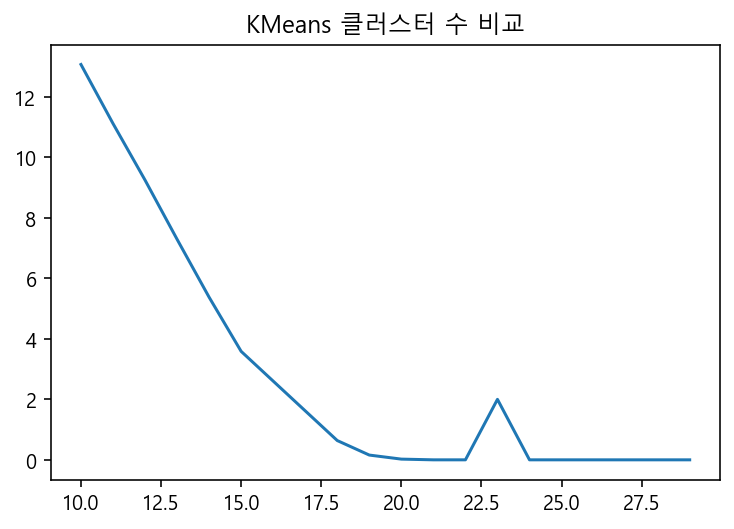

In [42]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 inertia 값을 넣어 그립니다.
# 클러스트의 개수가 커질 때마다 응집도가 높아진다. 클러스터링이 잘 됐다.

plt.plot(range(start, end), inertia)
plt.title("KMeans 클러스터 수 비교")

* 적정한 클러스터 갯수를 넣어 군집화 합니다.

In [43]:
# n_clusters 에 적절한 값을 넣어줍니다.
# fit.predict 를 하고 결과를 cluster 라는 새로운 컬럼에 담습니다.
n_clusters = 20
cls = KMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["cluster"] = prediction

In [49]:
df["cluster"].value_counts().head()

1    56
4     5
5     4
6     4
2     3
Name: cluster, dtype: int64

In [50]:
# 클러스터 센터
cc = cls.cluster_centers_

In [51]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

X_tsne = tsne.fit_transform(feature_tfidf)
X_tsne.shape

(97, 2)

In [52]:
df2d = pd.DataFrame(X_tsne, columns=['x', 'y'])
df2d.shape

(97, 2)

In [53]:
df2d["cluster"] = prediction
df2d.head()

,x,y,cluster
0,-3.369328,0.364506,19
1,-2.190988,0.350135,13
2,-0.451426,-1.173029,1
3,-1.397174,-1.374231,1
4,-1.470194,-1.616046,1


C:\Users\etlers\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

C:\Users\etlers\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\etlers\AppData\Roaming\Python\Python38\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


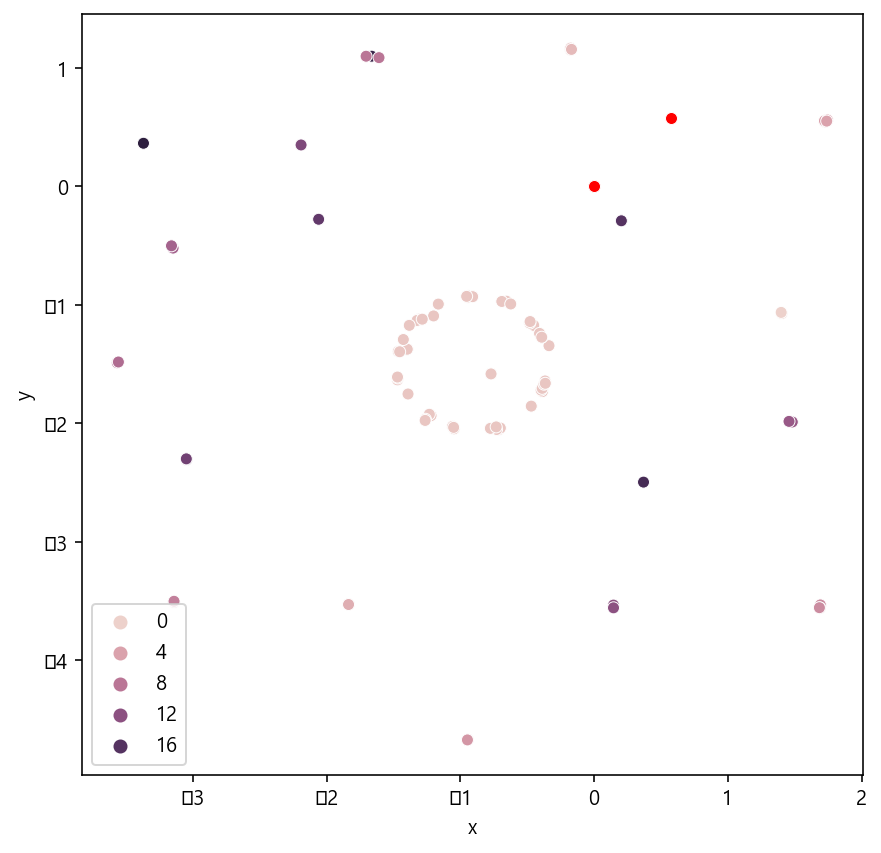

In [55]:
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df2d, x="x", y="y", hue="cluster")
sns.scatterplot(cc[:, 0], cc[:, 1],  color='red')

In [56]:
# df["cluster"] 의 빈도수를 value_counts로 세어봅니다.
df["cluster"].value_counts().head(10)

1     56
4      5
5      4
6      4
2      3
7      3
0      2
14     2
12     2
11     2
Name: cluster, dtype: int64

### MiniBatchKMeans
* [Comparison of the K-Means and MiniBatchKMeans clustering algorithms — scikit-learn 0.22.1 documentation](https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html)

In [57]:
# batch_size 를 쓸 수 있는 MiniBatchKMeans 로 군집화
from sklearn.cluster import MiniBatchKMeans
b_inertia = []

# 적절한 클러스터의 갯수를 알기 위해 inertia 값을 구함
# trange 를 통해 시작과 끝 값을 지정해 주면 진행 정도를 알 수 있습니다.
# b_inertia 리스트에 cls.inertia_ 값을 넣어줍니다.
for i in trange(start, end):
    cls = MiniBatchKMeans(n_clusters=i, random_state=42)
    cls.fit(feature_tfidf)
    b_inertia.append(cls.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.90it/s]


Text(0.5, 1.0, 'MiniBatchKMeans 클러스터 수 비교')

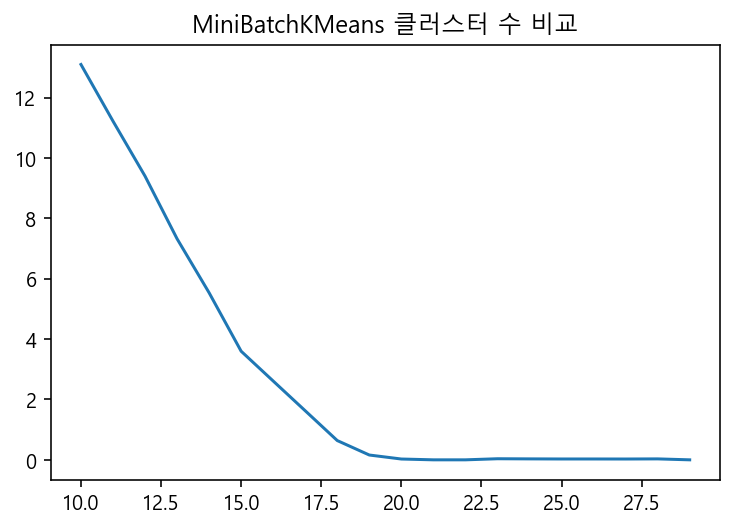

In [58]:
# 위에서 구한 값을 시각화 합니다.
# x축에는 클러스터의 수를 y축에는 b_inertia 값을 넣어 그립니다.
plt.plot(range(start, end), b_inertia)
plt.title("MiniBatchKMeans 클러스터 수 비교")

In [59]:
# MiniBatchKMeans 를 통해 학습을 시킵니다.
# 결과를 bcluster 라는 변수에 저장합니다.
cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)
cls.fit(feature_tfidf)
prediction = cls.predict(feature_tfidf)
df["bcluster"] = prediction

In [60]:
# bcluster의 빈도수를 구합니다.
df["bcluster"].value_counts().head(10)

1     56
0      5
4      4
5      4
9      3
6      3
14     2
12     2
11     2
10     2
Name: bcluster, dtype: int64

In [63]:
# 어떤 강좌명이 있는지 특정 클러스터의 값을 봅니다.  
df.loc[df["bcluster"] == 5, "course"].value_counts().head()

  스프링 부트 개념과 활용                          2
스프링 부트 배우고 싶습니다.\n#스프링 부트 개념과 활용         1
스프링 부트도 배워야 할거 같습니다 ㅜ\n#스프링 부트 개념과 활용    1
Name: course, dtype: int64

In [64]:
# bcluster, cluster, course 값을 미리보기 합니다.
df.loc[df["bcluster"] == 5, ["bcluster", "cluster", "course"]]

,bcluster,cluster,course
37,5,5,스프링 부트도 배워야 할거 같습니다 ㅜ\n#스프링 부트 개념과 활용
56,5,5,스프링 부트 배우고 싶습니다.\n#스프링 부트 개념과 활용
57,5,5,스프링 부트 개념과 활용
58,5,5,스프링 부트 개념과 활용


In [66]:
df.loc[df["bcluster"] == 5, ["bcluster", "cluster", "origin_text", "course"]].tail(10)

,bcluster,cluster,origin_text,course
37,5,5,스프링 부트도 배워야 할거 같습니다 ㅜ\n#스프링 부트 개념과 활용,스프링 부트도 배워야 할거 같습니다 ㅜ\n#스프링 부트 개념과 활용
56,5,5,스프링 부트 배우고 싶습니다.\n#스프링 부트 개념과 활용,스프링 부트 배우고 싶습니다.\n#스프링 부트 개념과 활용
57,5,5,스프링 부트 배울래요\n#관심강의 : 스프링 부트 개념과 활용,스프링 부트 개념과 활용
58,5,5,동료들과 함께 재밌게 공부하고 싶습니다.!!\n#관심강의 : 스프링 부트 개념과 활용,스프링 부트 개념과 활용


### 클러스터 예측 정확도 확인하기

In [67]:
# n_clusters 위에서 정의한 클러스터 수를 사용
feature_array = feature_vector.toarray()
# 예측한 클러스터의 유니크 값
labels = np.unique(prediction)
df_cluster_score = []
df_cluster = []
for label in labels:
    id_temp = np.where(prediction==label) # 예측한 값이 클러스터 번호와 매치 되는 것을 가져옴
    x_means = np.mean(feature_array[id_temp], axis = 0) # 클러스터의 평균 값을 구함
    sorted_means = np.argsort(x_means)[::-1][:n_clusters] # 값을 역순으로 정렬해서 클러스터 수 만큼 가져옴
    features = vectorizer.get_feature_names()
    best_features = [(features[i], x_means[i]) for i in sorted_means] 
    # 클러스터별 전체 스코어
    df_score = pd.DataFrame(best_features, columns = ['features', 'score'])
    df_cluster_score.append(df_score)
    # 클러스터 대표 키워드
    df_cluster.append(best_features[0])

In [68]:
# 개별 클러스터에서 점수가 가장 높은 단어를 추출 아래 점수가 클수록 예측 정확도가 높음
# MiniBatchKMeans 로 예측한 값 기준
pd.DataFrame(df_cluster, columns = ['features', 'score']).sort_values(by=["features", "score"], ascending=False)

,features,score
10,활용2 api 개발과 성능 최적화,1.0
18,활용2 api 개발과 성능 최적화,1.0
1,활용2 api 개발과 성능 최적화,0.0
4,홍정모의 따라하며 배우는,1.0
7,파이썬 데이터 분석 시작하기,1.0
17,파이썬 데이터 분석,1.0
3,입문 공공데이터로 파이썬 데이터,1.0
15,스프링 데이터 jpa,1.0
11,분석 실전 프로젝트,1.0
5,부트 개념과 활용,1.0


In [70]:
# score 정확도가 1이 나온 클러스터를 찾아봄 - 같은 강좌끼리 묶였는지 확인 함
df.loc[df["bcluster"] == 5, ["bcluster", "cluster", "origin_text", "course"]]

,bcluster,cluster,origin_text,course
37,5,5,스프링 부트도 배워야 할거 같습니다 ㅜ\n#스프링 부트 개념과 활용,스프링 부트도 배워야 할거 같습니다 ㅜ\n#스프링 부트 개념과 활용
56,5,5,스프링 부트 배우고 싶습니다.\n#스프링 부트 개념과 활용,스프링 부트 배우고 싶습니다.\n#스프링 부트 개념과 활용
57,5,5,스프링 부트 배울래요\n#관심강의 : 스프링 부트 개념과 활용,스프링 부트 개념과 활용
58,5,5,동료들과 함께 재밌게 공부하고 싶습니다.!!\n#관심강의 : 스프링 부트 개념과 활용,스프링 부트 개념과 활용


## WordCloud
* [amueller/word_cloud: A little word cloud generator in Python](https://github.com/amueller/word_cloud)
* 설치 방법 : [Wordcloud :: Anaconda Cloud](https://anaconda.org/conda-forge/wordcloud)

In [79]:
# 불용어 - 자주 등장하지만 의미가 크지 않아 제외하고 싶은 텍스트
stopwords = ["관심 강의", "관심강의", "관심", "강의", "강좌", "강의를",
             "올해", "올해는", "열심히", "공부를", "합니다", "하고", "싶어요", 
             "있는", "있습니다", "싶습니다", "2020년"]
# 불용어를 제거하지 않고 그리려면 아래 주석을 풀어서 stopword 변수에 덮어쓰기를 합니다.
stopwords = []
# displayWordCloud 라는 함수를 만들어 재사용합니다.
from wordcloud import WordCloud


def displayWordCloud(data = None, backgroundcolor = 'black', width=1280, height=768):
    wordcloud = WordCloud(
                        font_path = 'C:/Windows/Fonts/malgunbd.ttf', 
                        stopwords = stopwords, 
                        background_color = backgroundcolor, 
                        width = width, height = height, 
                        random_state=42).generate(data)
    plt.figure(figsize = (15 , 10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show() 

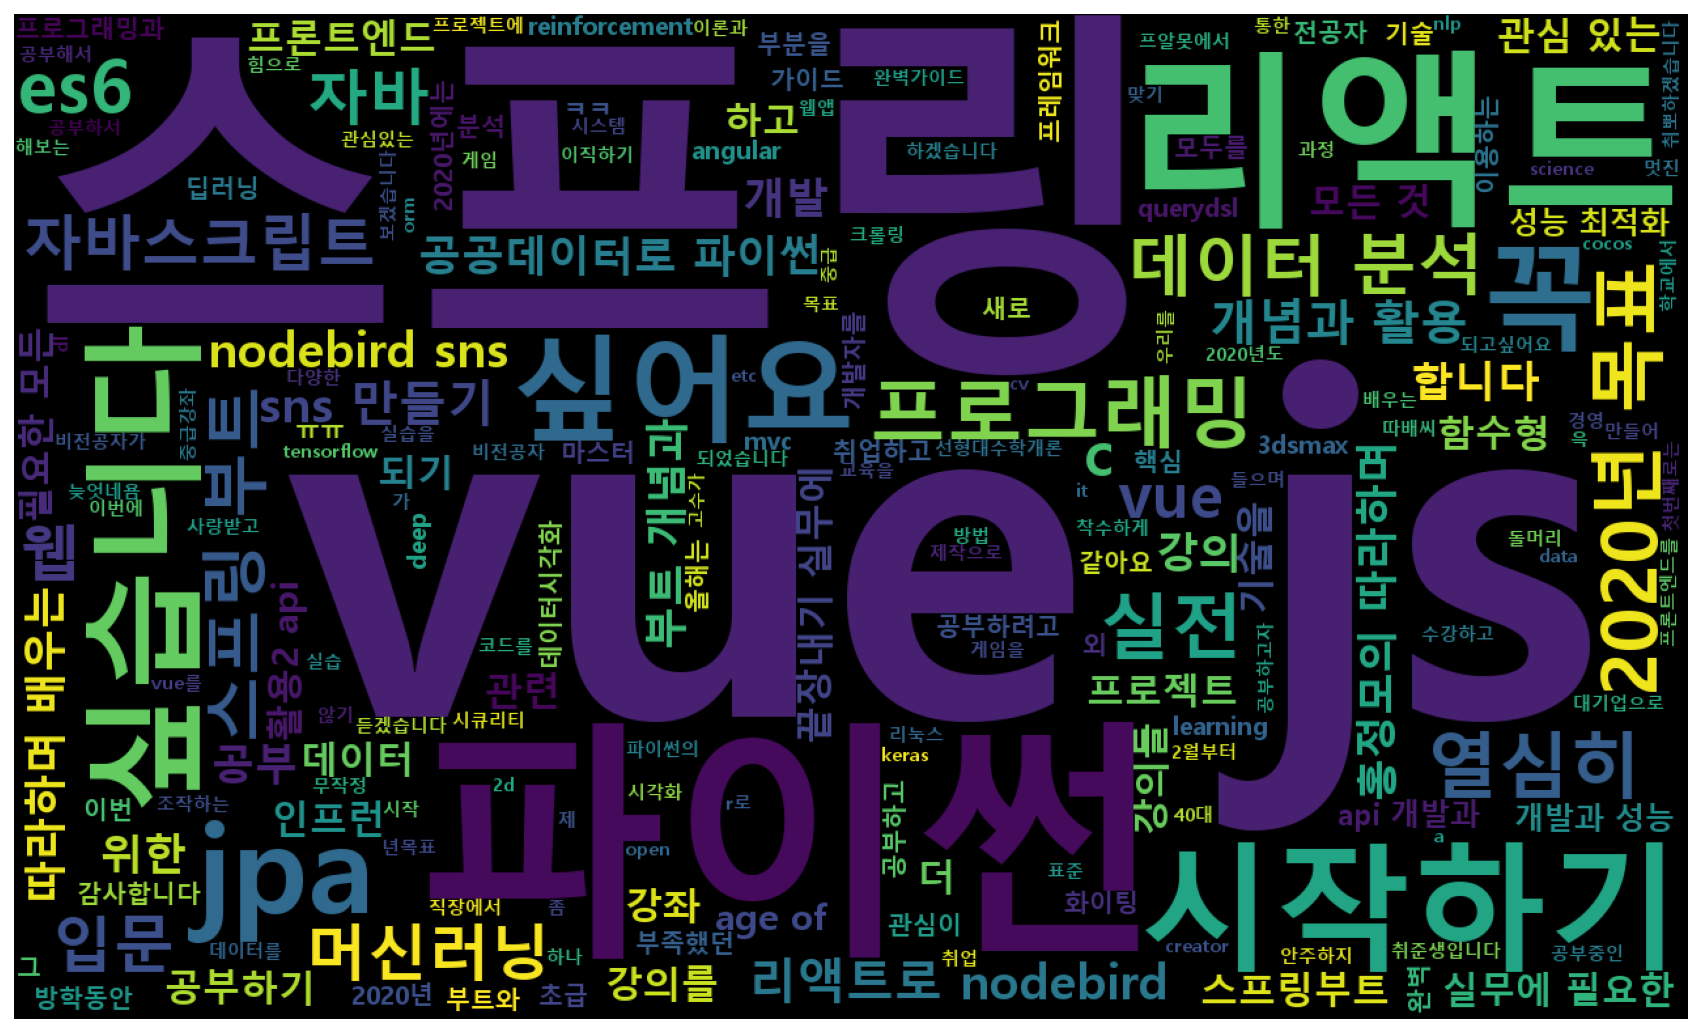

In [80]:
course_text = " ".join(df["course"])
displayWordCloud(course_text)